# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import plotly.express as px

ModuleNotFoundError: No module named 'numpy'

In [2]:
df = pd.read_csv('Pokemon.csv')
df.head(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


### Indentificando valores nulos/NaN

In [4]:
df['Type 2'].isnull().sum()

386

Os dados que não possuem entrada se referem aos pokemons únicamente tipados.

### Entendendo relações

Com o dataset analisado, podemos começar a gerar insights sobre o mesmo.

$$
    H0: Fd = Fu
$$

Aqui estamos tentando analisar se a força(Attack) dos pokemons duplamente tipados é superior aos unicamente tipados, utilizando o Teste t de Student para tal.

In [5]:
Fduplamente_tipados = df[df["Type 2"].notnull()]['Attack']
Funicamente_tipados = df[df["Type 2"].isnull()]['Attack']

alpha = 0.05 #Margem de erro para 95% de certeza
#Verificação pelo teste de levene para saber se as
#variâncias são iguais,então alterando o 
#param 'equal_var' do ttest de acordo

pForça = True
if sts.levene(Fduplamente_tipados,Funicamente_tipados).pvalue > alpha:
    pForça = False

if sts.ttest_ind(Fduplamente_tipados,Funicamente_tipados,equal_var=pForça).pvalue < alpha:
    print('Podemos inferir estatísticamente que nossa hipotese original é falsa.')
else:
    print('Nossa hipotese original é verdadeira, portanto não há diferença significativa entre a força de ataque.')    



Podemos inferir estatísticamente que nossa hipotese original é falsa.


Então, se a H0 é falsa, vamos entender qual o comportamento da força entre os tipos.
A força dos duplamente tipados é maior?
$$
H1: Fd > Fu
$$

In [6]:
alpha = 0.05
ForcaFinal = sts.ttest_ind(Fduplamente_tipados,Funicamente_tipados,equal_var=pForça,alternative='greater').pvalue
if ForcaFinal < alpha:
    print("H1 é verdadeira, logo a força de ataque dos duplamente tipados é maior")
else:
    print("H1 é falsa, então a força dos duplamente tipados é menor que a força dos unicamente tipados")

H1 é verdadeira, logo a força de ataque dos duplamente tipados é maior


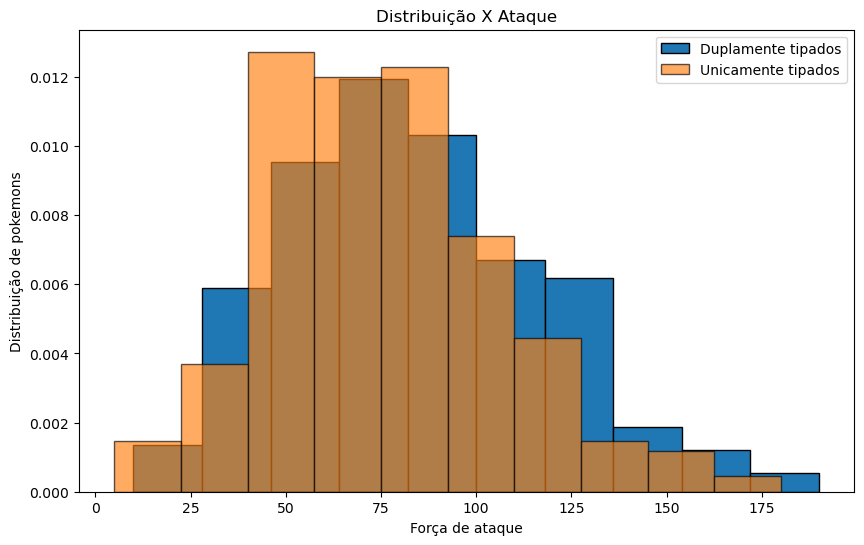

In [7]:
plt.figure(figsize=(10,6))
plt.hist(x = Fduplamente_tipados, edgecolor = 'black',density = True,label='Duplamente tipados')
plt.hist(x = Funicamente_tipados, edgecolor = 'black',density = True,alpha = 0.65,label='Unicamente tipados')
plt.xlabel("Força de ataque")
plt.ylabel("Distribuição de pokemons")
plt.title("Distribuição X Ataque")
plt.legend()
plt.show()

Agora, vamos fazer uma análise de dados para ver o balanceamento entre pokémons de ataque e defesa (ofensivos e defensivos)
$$
$$

In [8]:
df.rename(columns={
    'Type 1': 'Type1',
    'Type 2': 'Type2',
    'Sp. Atk': 'SpAtk',
    'Sp. Def': 'SpDef'
}, inplace=True)

In [9]:
df['AtaqueTotal'] = df['Attack'] + df['SpAtk']
df['DefesaTotal'] = df['Defense'] + df['SpDef']

In [10]:
df_type1 = df[['Name', 'Type1', 'AtaqueTotal', 'DefesaTotal']].rename(columns={'Type1': 'Type'})
df_type2 = df[['Name', 'Type2', 'AtaqueTotal', 'DefesaTotal']].rename(columns={'Type2': 'Type'}).dropna()
df_types = pd.concat([df_type1, df_type2], ignore_index=True)
# isso aqui "desagrupa" os tipos e cria uma tabela onde cada linha é um Pokémon e um de seus tipos
# e permite analisar os dados de um pokemon com dois tipos em dois grupos diferentes

In [11]:
type_stats = df_types.groupby('Type').agg(
    AtaqueMedio=('AtaqueTotal', 'mean'),
    DefesaMedia=('DefesaTotal', 'mean')
).reset_index()
# calcula as médias de ataque e defesa pra cada tipo

In [12]:
type_stats['Diferenca_Abs'] = abs(type_stats['AtaqueMedio'] - type_stats['DefesaMedia'])
type_stats_sorted = type_stats.sort_values(by='Diferenca_Abs').reset_index(drop=True)

In [13]:
results = []
for pokemon_type in df_types['Type'].unique():
    subset = df_types[df_types['Type'] == pokemon_type]
    
    # O teste só funciona com mais de um dado
    if len(subset) > 1:
        # Compara as duas colunas para ver se a diferença entre elas é significativa
        t_stat, p_value = sts.ttest_rel(subset['AtaqueTotal'], subset['DefesaTotal'])
        
        mean_atk = subset['AtaqueTotal'].mean()
        mean_def = subset['DefesaTotal'].mean()
        
        conclusion = "Não há diferença significativa"
        if p_value < 0.05:  # passou da margem de erro de 5%
            if mean_def > mean_atk:
                conclusion = "Defesa significativamente MAIOR que Ataque"
            else:
                conclusion = "Ataque significativamente MAIOR que Defesa"
    else:
        p_value, conclusion = (np.nan, "Dados insuficientes")
            
    results.append({'Type': pokemon_type, 'P-value': p_value, 'Conclusão': conclusion})

hypothesis_results = pd.DataFrame(results)

In [14]:
final_table = pd.merge(type_stats_sorted, hypothesis_results, on='Type')
# junta todas as informações em uma tabela final

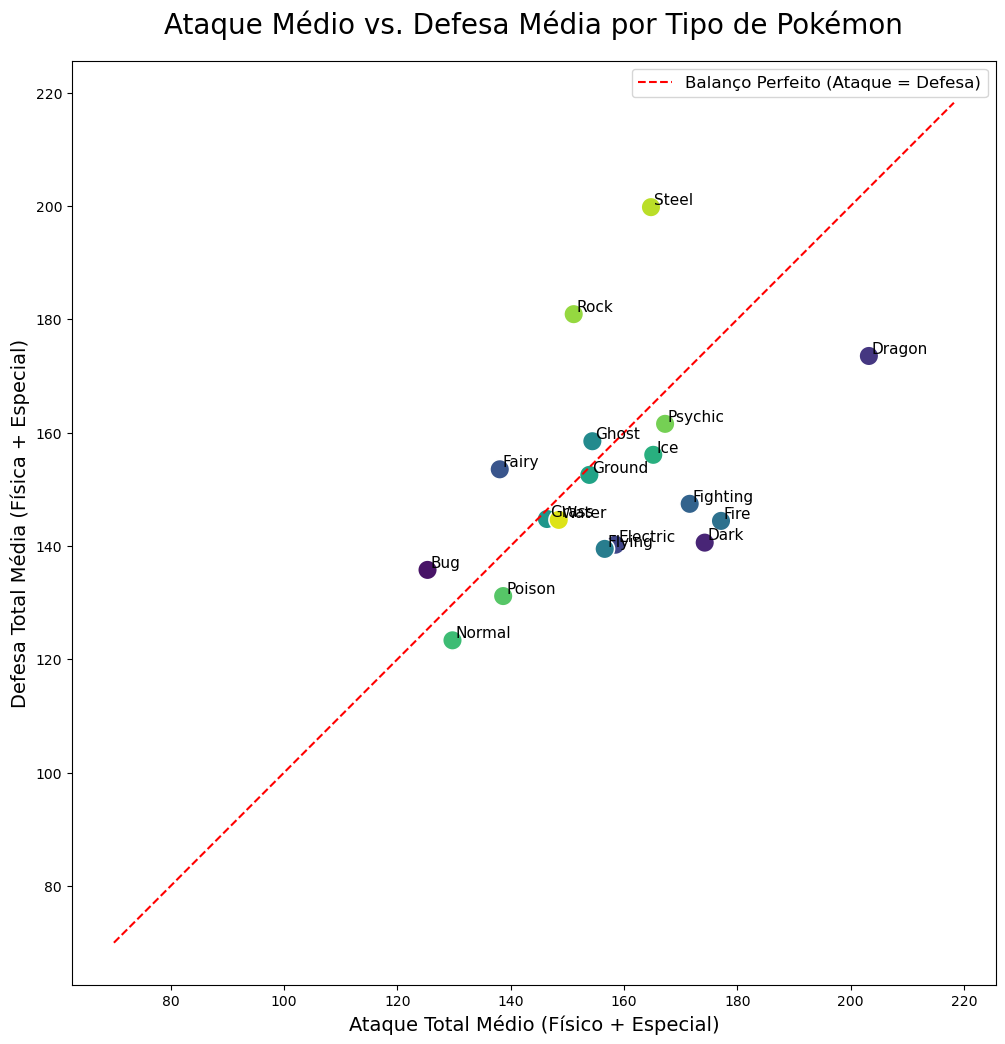

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(
    data=type_stats,
    x='AtaqueMedio',
    y='DefesaMedia',
    hue='Type',
    palette='viridis',
    s=200, # tamanho dos pontos
    legend=False # nomes dos tipos serão colocados manualmente
)
max_val = max(type_stats['AtaqueMedio'].max(), type_stats['DefesaMedia'].max()) + 15
ax.plot([70, max_val], [70, max_val], 'r--', label='Balanço Perfeito (Ataque = Defesa)')
# adiciona uma linha de referencia onde y=x para indicar o balanço perfeito
for i in range(type_stats.shape[0]):
    ax.text(
        x=type_stats['AtaqueMedio'][i] + 0.5,
        y=type_stats['DefesaMedia'][i] + 0.5,
        s=type_stats['Type'][i],
        fontdict=dict(color='black', size=11)
    )
    # adiciona os nomes dos tipos no gráfico 
ax.set_title('Ataque Médio vs. Defesa Média por Tipo de Pokémon', fontsize=20, pad=20)
ax.set_xlabel('Ataque Total Médio (Físico + Especial)', fontsize=14)
ax.set_ylabel('Defesa Total Média (Física + Especial)', fontsize=14)
ax.legend(fontsize=12)
ax.set_aspect('equal', adjustable='box')
# peguei uma ajuda de IA pra fazer essa parada das labels e configs finais


O gráfico acima mostra o perfil de batalha de cada tipo de Pokémon, comparando o ataque médio com a defesa média. A linha diagonal vermelha representa o balanço perfeito entre os dois. Os tipos que aparecem acima da linha, como Aço e Pedra, são especialistas defensivos. os tipos abaixo da linha, como Dragão e Psíquico, são tipos mais ofensivos com defesas proporcionalmente menores. E, tipos próximos à linha, como Normal, são os mais equilibrados, sem uma inclinação estatística forte para ataque ou defesa, o que os torna mais versáteis.
$$
$$